# Demand Forecasting using SARIMAX
This notebook demonstrates the use of SARIMAX for forecasting retail demand using exogenous variables.

In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('retail_store_inventory_preprocessed.csv')
df['Date'] = pd.to_datetime(df['Date'])

## Aggregate data by Date
We sum `Units Sold` and average the exogenous variables to prepare a time series.

In [4]:
daily_df = df.groupby('Date').agg({
    'Units Sold': 'sum',
    'Inventory Level': 'mean',
    'Price': 'mean',
    'Discount': 'mean',
    'Weather Condition': 'mean',
    'Holiday/Promotion': 'mean',
    'Competitor Pricing': 'mean',
    'Seasonality': 'mean'
}).reset_index()

## Visualize the sales trend

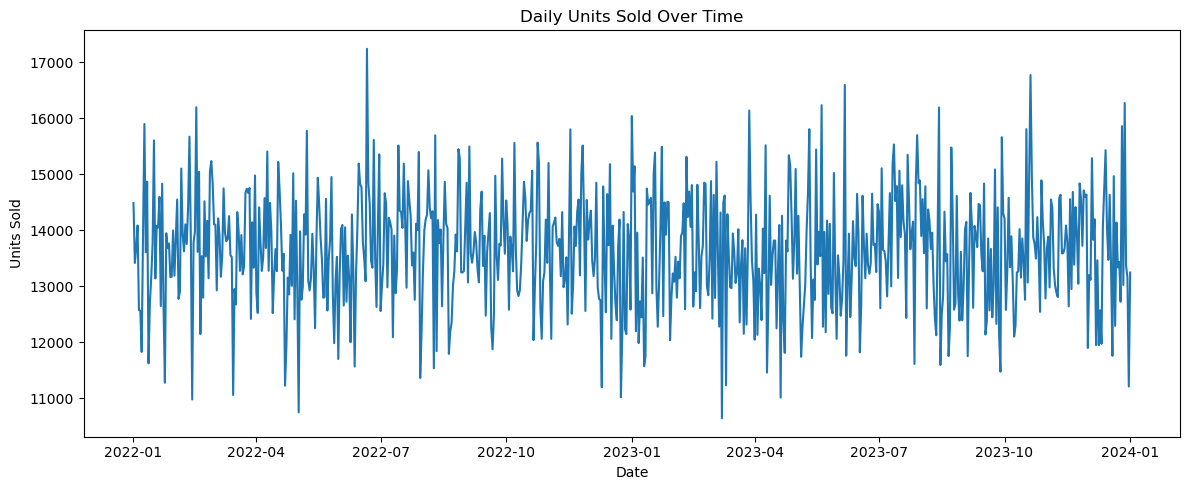

In [6]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_df, x='Date', y='Units Sold')
plt.title('Daily Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.tight_layout()
plt.show()

## Train SARIMAX model

In [8]:
# Prepare data
daily_df.set_index('Date', inplace=True)
train = daily_df.iloc[:-30]
test = daily_df.iloc[-30:]

endog_train = train['Units Sold']
exog_train = train.drop(columns=['Units Sold'])
endog_test = test['Units Sold']
exog_test = test.drop(columns=['Units Sold'])

In [9]:
# Fit model
model = SARIMAX(endog_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(0, 1, 1, 7),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Forecast and Evaluate

In [11]:
forecast = results.predict(start=test.index[0], end=test.index[-1], exog=exog_test)

mae = mean_absolute_error(endog_test, forecast)
rmse = np.sqrt(mean_squared_error(endog_test, forecast))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 754.24, RMSE: 963.41


## Plot Forecast vs Actual

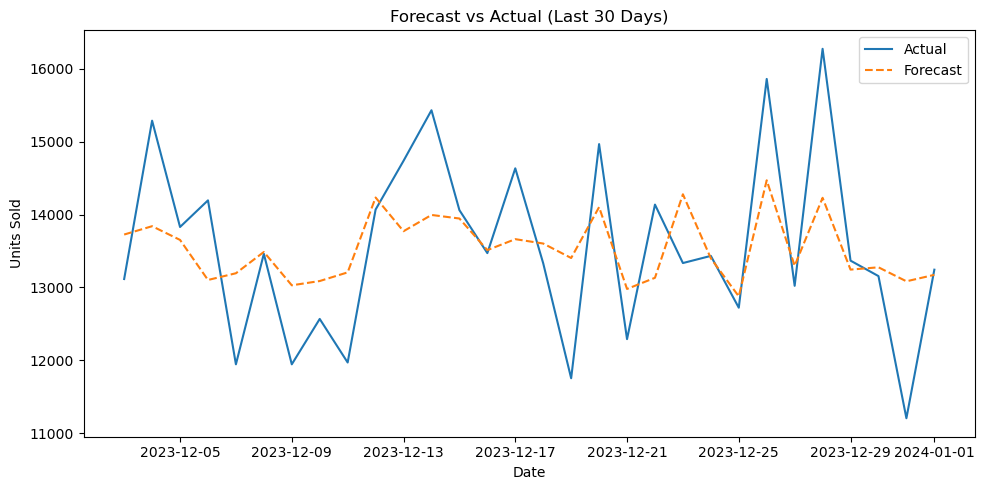

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, endog_test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Forecast vs Actual (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

## Save the model for deployment

In [24]:
import joblib
results.save("sarimax_model.sm")
